# Model Training

PKFold 및 Model Traning

① 환경 구성
라이브러리 불러오기
데이터 불러오기

② Purged K-fold for Cross-Validation
기존의 Cross-Validation의 취약점인 Overfitting을 보완하기 위한 PKFold Cross Validation 사용

③ Find the best param for bagging(RandomForest) with grid-search

다음 순서로 학습 진행 (RandomForest -> Bagging -> GridSearchCV)
Bagging은 RandomForest Classifier를 통해 생긴 오차의 분산을 줄이기 위해 사용
GridSearchCV는 최적의 Parameter 값을 얻기 위해 사용

# 1. 환경구성 및 데이터 불러오기

In [1]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [2]:
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

In [3]:
df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [4]:
df_data['t_value'].value_counts()

1.0    481
0.0    476
Name: t_value, dtype: int64

In [5]:
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

In [6]:
X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [7]:
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000]
train_y = train_y[:1000]

# 2. Purged K-fold for Cross-Validation

Cross-Validation은 학습시 과적합을 막기 위한 하나의 방도로 데이터를 K개의 부분집합으로 나누어, K-1개의 부분집합으로 학습을 진행하고, 나머지 하나의 부분집합으로 검증을 진행하는 방식입니다. 여기서 소개하는 Purged라는 개념은 학습데이터와 검증데이터를 나눌 때 두 시계열 사이의 연관성을 최대한 배제하기 위한 방법입니다.

일단, K-fold CV의 단점부터 알아보겠습니다.
관측치들이 Independent & Identical Distribution, IID 상태에서 추출됐다고 가정하기 어렵습니다.
테스트 집합 또한 모델 개발 과정에서 여러번 반복하여 사용되었을 가능성이 높습니다.
이 과정에서 여러 Bias가 반영되었을 가능성이 농후합니다.
정보 누수, Leakage는 학습데이터에 검증데이터와 유사한 패턴이 많이 담길수록 정도가 심해지는 경향이 있습니다.

자기상관이 강한 시계열의 Feature X, 그와 관련된 Label Y가 있다고 가정해 봅시다.
자기상관이 강한 시계열이며, Label이 중첩되어 있는 데이터에 의해 유도.
이 경우, time t와 t+l의 데이터를 학습데이터와 검증데이터에 각각 둔다면, 정보의 누수가 발생됩니다.
예를 들어, t시점에 대한 데이터가 학습에, t+l에 대한 데이터가 검증데이터에 있다면,
이 학습데이터로 학습된 분류기는 학습데이터에서 이미 경험한 t+l에 대한 예측성능이 좋을 것입니다.
이러한 데이터가 많으면 많을수록 분류기의 성능은 과대하게 좋은 것으로 인식될 공산이 큽니다.
따라서, 정보의 누수를 최대한 줄이는 것이 분류기 성능의 객관성을 확보하는데 관건이 됩니다.


어떻게 해야 이를 줄일 수 있을까요?

모든 관측값에 대해 학습데이터와 검증데이터가 최대한 상관되지 않도록 시계열 집합간 일종의 시간차를 둡니다.
분류기의 Overfitting을 막기 위한 방안을 사용합니다. (Early Stopping, Regulization 등)
여기서, 시계열 집합간 일종의 시간차를 두는 것을 Purged 라고 합니다.
여기서는 PKFold 클래스를 통해 이를 구현합니다.

In [8]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

# 3. Find the best param for bagging(RandomForest) with grid-search

ROC 곡선은 다양한 임계값에서 모델의 분류 성능에 대한 측정 그래프이며 좋은 성능의 분류 모델은 AUC 값이 1에 가까워집니다. 반대로 성능이 좋지 못한 분류 모델의 경우 0에 가까워집니다. 이 말의 뜻은 분류를 정확히 하지 못하는 경우를 말합니다.

ROC, Receiver Operating Characteristic : 그래프에서 곡선으로 휘어지거나 계단형태로 나타나는 부분
AUC, Area Under the Curve : 그래프에서 곡선 혹은 계단형태 아래에 해당하는 영역

In [9]:
# 최대 20분정도가 소요됩니다. 시간이 부족하다면 파라미터를 조절하여 진행하세요.
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }
             
rfc = RandomForestClassifier(class_weight='balanced')
bag_rfc = BaggingClassifier(rfc)
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)
gs_rfc.fit(train_x, train_y)
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [12]:
gs_rfc_best.fit(train_x, train_y)

BaggingClassifier(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                        max_depth=20,
                                                        max_features=None,
                                                        min_samples_leaf=10),
                  max_features=0.7)

In [13]:
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [14]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[86 50]
 [12 43]]
정확도:0.675392670157068, 정밀도:0.46236559139784944, 재현율:0.7818181818181819


auc:0.7070855614973262


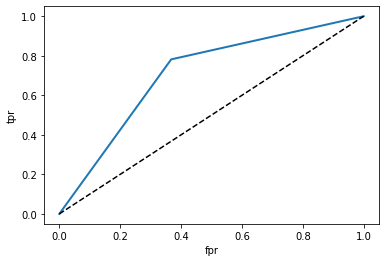

In [15]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')